<a href="https://colab.research.google.com/github/Noufal21/text-mining/blob/master/project/ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install attention


In [3]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import gensim
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Bidirectional, TimeDistributed, Lambda, Attention
from keras.layers.core import Lambda
from keras.layers.merge import concatenate, add, multiply
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.noise import GaussianNoise
import keras
from keras.models import Sequential
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.layers.advanced_activations import PReLU
from keras.layers import add
import functools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
from nltk.corpus import stopwords

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K

#from att2 import Attention2
#from attention import Attention

In [11]:
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300
BATCH_SIZE = 1024


In [12]:
file_name = "/content/filter_train.csv.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [17]:
file_name = "/content/filter_train_features_glove.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [21]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-01-17 11:09:33--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.69.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.69.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  79.8MB/s    in 20s     

2021-01-17 11:09:53 (79.2 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!wget -c "http://nlp.stanford.edu/data/glove.840B.300d.zip"

--2021-01-06 20:19:29--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-01-06 20:19:30--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-01-06 20:19:30--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
file_name = "/content/glove.840B.300d.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [22]:
embedding_file = "/content/GoogleNews-vectors-negative300.bin.gz"
w2v = gensim.models.KeyedVectors.load_word2vec_format(embedding_file, binary=True)


In [ ]:
# -*- coding: utf-8 -*-
"""
word2vec embeddings start with a line with the number of lines (tokens?) and 
the number of dimensions of the file. This allows gensim to allocate memory 
accordingly for querying the model. Larger dimensions mean larger memory is 
held captive. Accordingly, this line has to be inserted into the GloVe 
embeddings file.
"""

import os
import shutil
import smart_open
from sys import platform

import gensim


def prepend_line(infile, outfile, line):
	""" 
	Function use to prepend lines using bash utilities in Linux. 
	(source: http://stackoverflow.com/a/10850588/610569)
	"""
	with open(infile, 'r') as old:
		with open(outfile, 'w') as new:
			new.write(str(line) + "\n")
			shutil.copyfileobj(old, new)

def prepend_slow(infile, outfile, line):
	"""
	Slower way to prepend the line by re-creating the inputfile.
	"""
	with open(infile, 'r') as fin:
		with open(outfile, 'w') as fout:
			fout.write(line + "\n")
			for line in fin:
				fout.write(line)

def get_lines(glove_file_name):
    """Return the number of vectors and dimensions in a file in GloVe format."""
    with smart_open.smart_open(glove_file_name, 'r') as f:
        num_lines = sum(1 for line in f)
    with smart_open.smart_open(glove_file_name, 'r') as f:
        num_dims = len(f.readline().split()) - 1
    return num_lines, num_dims
	
# Input: GloVe Model File
# More models can be downloaded from http://nlp.stanford.edu/projects/glove/
glove_file="/content/glove.840B.300d.txt"

num_lines, dims = get_lines(glove_file)

# Output: Gensim Model text format.
gensim_file='glove_model2.txt'
gensim_first_line = "{} {}".format(num_lines, dims)

# Prepends the line.
if platform == "linux" or platform == "linux2":
	prepend_line(glove_file, gensim_file, gensim_first_line)
else:
	prepend_slow(glove_file, gensim_file, gensim_first_line)

# Demo: Loads the newly created glove_model.txt into gensim API.
glove = gensim.models.KeyedVectors.load_word2vec_format(gensim_file,binary=False) #GloVe Model

In [13]:
train_df = pd.read_csv("/content/filter_train.csv")
train_df = train_df.dropna()
train_df = train_df.sort_values('id').reset_index()
train_df.head(12)

,index,id,qid1,qid2,question1,question2,is_duplicate,0
0,404286,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1
1,134758,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,1
2,134759,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1
3,134760,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math]23^{24}[/math is ...,0,1
4,134761,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,1
5,134762,5,11,12,astrology i am a capricorn sun cap moon and ca...,i am a triple capricorn sun moon and ascendant...,1,1
6,134763,6,13,14,should i buy tiago,what keeps childern active and far from phone ...,0,1
7,134764,7,15,16,how can i be a good geologist,what should i do to be a great geologist,1,1
8,134765,8,17,18,when do you use instead of,when do you use instead of and,0,1
9,134766,9,19,20,motorola company can i hack my charter motorol...,how do i hack motorola dcx3400 for free internet,0,1


In [18]:
train_feat = pd.read_pickle("/content/filter_train_features_glove")
train_feat.head(12)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,longest_substr_ratio,wmd,wmd_norm,cos,city,jacc,canb,eucl,mink,bray,q1_skew,q2_skew,q1_kurt,q2_kurt
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0,1,2,13.0,93,95,100,100,88,100,93,0.999998,1.216034,0.179328,0.031762,3.456409,1.0,91.349971,0.252040,0.114783,0.166479,2.158090,2.455419,25.021148,26.141845
1,0.799984,0.499994,0.599988,0.499992,0.699993,0.466664,0,1,5,12.5,65,86,73,100,73,86,63,0.583332,4.141246,0.617247,0.168384,7.369193,1.0,126.314924,0.580316,0.306059,0.303183,-0.257926,-0.916361,1.543840,8.592215
2,0.599988,0.599988,0.399992,0.222220,0.499995,0.357140,0,1,4,12.0,43,60,46,100,71,63,63,0.172413,3.403840,0.503602,0.112211,6.565957,1.0,133.118472,0.473731,0.215851,0.285214,0.747187,-0.135832,11.994413,9.117429
3,0.000000,0.000000,0.249994,0.142855,0.111110,0.090908,0,0,2,10.0,9,27,9,32,30,28,24,0.041667,7.005262,1.173771,0.504341,13.889997,1.0,204.769694,1.004332,0.457859,0.777993,0.898184,2.689361,17.295620,30.819242
4,0.499988,0.222220,0.666644,0.499988,0.571420,0.307690,0,1,6,10.0,36,86,55,100,67,67,47,0.157894,6.559568,0.914615,0.259966,9.750399,1.0,162.340725,0.721063,0.340345,0.443021,0.050815,0.408724,8.666970,9.695792
5,0.599988,0.499992,0.899991,0.818174,0.705878,0.705878,1,0,0,17.0,73,77,73,100,73,81,77,0.182927,4.363822,0.656053,0.162851,7.753427,1.0,129.783937,0.570704,0.268333,0.318616,-0.607014,-0.848560,7.657380,3.520004
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,7,7.5,20,35,39,39,39,24,23,0.111110,8.360494,1.315252,0.813989,16.096066,1.0,209.661643,1.275922,0.660120,0.876221,-0.153566,0.587522,0.347224,28.210168
7,0.499975,0.499975,0.599988,0.428565,0.571420,0.444440,1,0,2,8.0,61,67,66,100,69,71,61,0.344826,1.510052,0.281362,0.054163,4.542877,1.0,100.792654,0.329130,0.150444,0.183996,1.048181,1.105783,8.640427,8.392096
8,0.999950,0.999950,0.999975,0.799984,0.999983,0.857131,0,1,1,6.5,93,95,100,100,100,100,93,0.999996,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.171160,1.171160,16.944106,16.944106
9,0.599988,0.499992,0.333322,0.249994,0.444440,0.444440,0,0,0,9.0,50,62,56,100,55,65,44,0.208333,4.897002,0.721900,0.241410,9.754137,1.0,153.969825,0.694852,0.316839,0.407277,-0.367810,-0.379719,2.199797,7.115269


In [ ]:
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

def tfidf_word_match_share_stops(row, stops=None, weights=None):
    q1words = {}
    q2words = {}
    for word in row[4]:
        if word not in stops:
            q1words[word] = 1
    for word in row[5]:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

def tfidf_word_match_share(row, weights=None):
    q1words = {}
    q2words = {}
    
    for word in row[4]:
        q1words[word] = 1
    for word in row[5]:
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R


train_qs = pd.Series(train_df['question1'].tolist() + train_df['question2'].tolist())
words = [x for y in train_qs for x in y]
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
stops = set(stopwords.words("english"))
f = functools.partial(tfidf_word_match_share, weights=weights)
train_feat['tfidf_wm'] = train_df.apply(f, axis=1, raw=True) #2

f = functools.partial(tfidf_word_match_share_stops, stops=stops, weights=weights)
train_feat['tfidf_wm_stops'] = train_df.apply(f, axis=1, raw=True) #3

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
tfidf_txt = pd.Series(train_df['question1'].tolist() + train_df['question2'].tolist()).astype(str)
tfidf.fit_transform(tfidf_txt)

train_feat['z_tfidf_sum1'] = train_df.question1.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
train_feat['z_tfidf_sum2'] = train_df.question2.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
train_feat['z_tfidf_mean1'] = train_df.question1.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
train_feat['z_tfidf_mean2'] = train_df.question2.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
train_feat['z_tfidf_len1'] = train_df.question1.map(lambda x: len(tfidf.transform([str(x)]).data))
train_feat['z_tfidf_len2'] = train_df.question2.map(lambda x: len(tfidf.transform([str(x)]).data))

In [ ]:
train_feat.head()

In [14]:
def generate_embedding_matrix(word_index, word2vec, embedding_dim):
    # generate embedding matrix from word vectors
    nb_words = len(word_index) + 1        
    embedding_matrix = np.zeros((nb_words, embedding_dim))
    for word, i in word_index.items():
        if word in word2vec.vocab:
            embedding_matrix[i] = word2vec.word_vec(word)   
    return embedding_matrix

In [15]:
def makeData(train_df,train_feat):
  question1 = train_df.question1.astype(str)
  question2 = train_df.question2.astype(str)
  tokenizer = Tokenizer(filters="")
  tokenizer.fit_on_texts( question1 + question2)
  word_index = tokenizer.word_index
  q1_data = pad_sequences(tokenizer.texts_to_sequences(question1), maxlen=MAX_SEQUENCE_LENGTH)
  q2_data = pad_sequences(tokenizer.texts_to_sequences(question2), maxlen=MAX_SEQUENCE_LENGTH)
  labels = np.array(train_df.is_duplicate)

  msk = np.random.rand(len(question1)) < 0.9
  q1_data_train = q1_data[msk]
  q2_data_train = q2_data[msk]
  labels_train = labels[msk]
  feat_train = train_feat[msk]
  val_msk = np.random.rand(len(q1_data_train)) < 0.8

  q1_data_val = q1_data_train[~val_msk]
  q2_data_val = q2_data_train[~val_msk]
  labels_val = labels_train[~val_msk]
  feat_val = feat_train[~val_msk]

  q1_data_train = q1_data_train[val_msk]
  q2_data_train = q2_data_train[val_msk]
  labels_train = labels_train[val_msk]
  feat_train = feat_train[val_msk]



  q1_data_test = q1_data[~msk]
  q2_data_test = q2_data[~msk]
  labels_test = labels[~msk]
  feat_test = train_feat[~msk]
  return word_index, q1_data_train, q2_data_train,feat_train, labels_train,  q1_data_val, q2_data_val, feat_val, labels_val, q1_data_test, q2_data_test, feat_test, labels_test

In [19]:
 word_index, q1_data_train, q2_data_train,feat_train, labels_train,  q1_data_val, q2_data_val, feat_val, labels_val, q1_data_test, q2_data_test, feat_test, labels_test = makeData(train_df,train_feat)

In [24]:
embeddingMatrix = generate_embedding_matrix(word_index,w2v,EMBEDDING_DIM)

In [4]:
def lstm_Model():
  nb_words = len(word_index) + 1
  embedding_layer = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embeddingMatrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
  lstm_layer = LSTM(200, recurrent_dropout=0.2,dropout = 0.2)
  sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_1 = embedding_layer(sequence_1_input)
  x1 = lstm_layer(embedded_sequences_1)
  

  sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_2 = embedding_layer(sequence_2_input)
  y1 = lstm_layer(embedded_sequences_2)
  

  features_input = Input(shape=(feat_train.shape[1],), dtype="float32")
  features_dense = Dense(150, activation="relu")(features_input)
  features_dense = Dropout(0.25)(features_dense)
  #features_dense = BatchNormalization()(features_dense)
  features_dense = Dense(300, activation="relu")(features_dense)
  features_dense = Dropout(0.2)(features_dense)


  addition = add([x1, y1])
  minus_y1 = Lambda(lambda x: -x)(y1)
  merged = add([x1, minus_y1])
  merged = multiply([merged, merged])
  merged = concatenate([merged, addition])
  merged = Dropout(0.3)(merged)

  merged = concatenate([merged, features_dense])
  #merged = BatchNormalization()(merged)
  #merged = GaussianNoise(0.1)(merged)

  merged = Dense(300, activation="relu")(merged)
  merged = Dropout(0.25)(merged)
  merged = BatchNormalization()(merged)
  merged = Dense(100, activation="relu")(merged)
  merged = Dropout(0.25)(merged)
  merged = BatchNormalization()(merged)
  merged = Dense(100, activation="relu")(merged)
  merged = Dropout(0.25)(merged)
  merged = Dense(50, activation="relu")(merged)
  merged = Dropout(0.25)(merged)


  out = Dense(1, activation="sigmoid")(merged)

  model = Model(inputs=[sequence_1_input, sequence_2_input, features_input], outputs=out)
  model.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Nadam(learning_rate= 0.0003),metrics = ['accuracy'])

  return model
    
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
best_model_path = "best_model"  + ".h5"
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)
variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001)

In [ ]:


new_model = lstm_Model()
class_weight = {0: 1.309028344, 1: 0.472001959}
class_weight = {0: 0.792667958149676, 1: 1.3542103535370453}
LSTM_model = lstm_Model()
hist = LSTM_model.fit([q1_data_train, q2_data_train, feat_train], labels_train,
                     validation_data=([q1_data_val, q2_data_val, feat_val], labels_val),
                     epochs=15, batch_size=BATCH_SIZE, shuffle=True,class_weight = class_weight,
                     callbacks=[early_stopping, model_checkpoint,variable_gradient], verbose=1)

Epoch 1/15
285/285 [==============================] - 65s 208ms/step - loss: 0.6068 - accuracy: 0.6340 - val_loss: 0.4802 - val_accuracy: 0.7390
Epoch 2/15
285/285 [==============================] - 60s 210ms/step - loss: 0.4914 - accuracy: 0.7255 - val_loss: 0.4738 - val_accuracy: 0.7309
Epoch 3/15
285/285 [==============================] - 59s 207ms/step - loss: 0.4600 - accuracy: 0.7503 - val_loss: 0.4260 - val_accuracy: 0.7804
Epoch 4/15
285/285 [==============================] - 59s 209ms/step - loss: 0.4392 - accuracy: 0.7660 - val_loss: 0.4360 - val_accuracy: 0.7674
Epoch 5/15
285/285 [==============================] - 59s 207ms/step - loss: 0.4220 - accuracy: 0.7793 - val_loss: 0.4025 - val_accuracy: 0.7966
Epoch 6/15
285/285 [==============================] - 60s 212ms/step - loss: 0.4087 - accuracy: 0.7893 - val_loss: 0.3867 - val_accuracy: 0.8115
Epoch 7/15
285/285 [==============================] - 60s 209ms/step - loss: 0.3985 - accuracy: 0.7982 - val_loss: 0.3873 - val_ac

In [ ]:
LSTM_model.evaluate([q1_data_test,q2_data_test,feat_test], labels_test, batch_size=BATCH_SIZE)

40/40 [==============================] - 1s 33ms/step - loss: 0.3702 - accuracy: 0.8171


[0.3701944053173065, 0.8171167373657227]

**Filter Data and glove**

[0.36621272563934326, 0.8230683207511902]

[0.3709457516670227, 0.8191161751747131]

**Filter Data and word2vec**

[0.36660221219062805, 0.8261858820915222]

**Stem data and word2vec**

[0.3999842405319214, 0.7983471155166626]

**stem data and glove**

[0.6587316989898682, 0.6933504939079285]



In [5]:
def bilstm_Model():
  nb_words = len(word_index) + 1
  embedding_layer = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embeddingMatrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
  lstm_layer = Bidirectional(LSTM(300, recurrent_dropout=0.2,dropout = 0.2))

  sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_1 = embedding_layer(sequence_1_input)
  x1 = lstm_layer(embedded_sequences_1)

  sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_2 = embedding_layer(sequence_2_input)
  y1 = lstm_layer(embedded_sequences_2)

  features_input = Input(shape=(feat_train.shape[1],), dtype="float32")
  features_dense = Dense(150, activation="relu")(features_input)
  features_dense = Dropout(0.25)(features_dense)
  #eatures_dense = BatchNormalization()(features_dense)
  features_dense = Dense(300, activation="relu")(features_dense)
  features_dense = Dropout(0.2)(features_dense)


  addition = add([x1, y1])
  minus_y1 = Lambda(lambda x: -x)(y1)
  merged = add([x1, minus_y1])
  merged = multiply([merged, merged])
  merged = concatenate([merged, addition])
  merged = Dropout(0.3)(merged)

  merged = concatenate([merged, features_dense])
  #merged = BatchNormalization()(merged)
  #merged = GaussianNoise(0.1)(merged)

  merged = Dense(300, activation="relu")(merged)
  merged = Dropout(0.25)(merged)
  merged = BatchNormalization()(merged)
  merged = Dense(100, activation="relu")(merged)
  merged = Dropout(0.25)(merged)
  merged = BatchNormalization()(merged)
  merged = Dense(100, activation="relu")(merged)
  merged = Dropout(0.25)(merged)

  out = Dense(1, activation="sigmoid")(merged)

  model = Model(inputs=[sequence_1_input, sequence_2_input, features_input], outputs=out)
  model.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Nadam(learning_rate= 0.0003),metrics = ['accuracy'])

  return model
    
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
best_model_path = "bi best_model"  + ".h5"
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)
variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001)

In [ ]:
class_weight = {0: 0.792667958149676, 1: 1.3542103535370453}
biLSTM_model = bilstm_Model()
bi_hist = biLSTM_model.fit([q1_data_train, q2_data_train, feat_train], labels_train,
                     validation_data=([q1_data_val, q2_data_val, feat_val], labels_val),
                     epochs=20, batch_size=BATCH_SIZE, shuffle=True,class_weight = class_weight,
                     callbacks=[early_stopping, model_checkpoint,variable_gradient], verbose=1)

Epoch 1/20
285/285 [==============================] - 137s 439ms/step - loss: 0.5942 - accuracy: 0.6542 - val_loss: 0.4584 - val_accuracy: 0.7522
Epoch 2/20
285/285 [==============================] - 123s 433ms/step - loss: 0.4701 - accuracy: 0.7455 - val_loss: 0.4397 - val_accuracy: 0.7634
Epoch 3/20
285/285 [==============================] - 123s 433ms/step - loss: 0.4390 - accuracy: 0.7671 - val_loss: 0.4400 - val_accuracy: 0.7675
Epoch 4/20
285/285 [==============================] - 124s 436ms/step - loss: 0.4180 - accuracy: 0.7830 - val_loss: 0.4123 - val_accuracy: 0.7897
Epoch 5/20
285/285 [==============================] - 124s 435ms/step - loss: 0.4037 - accuracy: 0.7934 - val_loss: 0.4292 - val_accuracy: 0.7809
Epoch 6/20
285/285 [==============================] - 124s 437ms/step - loss: 0.3869 - accuracy: 0.8041 - val_loss: 0.3706 - val_accuracy: 0.8197
Epoch 7/20
285/285 [==============================] - 125s 439ms/step - loss: 0.3751 - accuracy: 0.8144 - val_loss: 0.3608 -

In [ ]:
biLSTM_model.evaluate([q1_data_test,q2_data_test,feat_test], labels_test, batch_size=BATCH_SIZE)

40/40 [==============================] - 3s 65ms/step - loss: 0.3480 - accuracy: 0.8404


[0.3479742109775543, 0.8403991460800171]

**Filter data and Glove**

[0.3561573326587677, 0.8351366519927979]

**Filter data and word2vec**

[0.3683305084705353, 0.8210417032241821]

**stem data and word2vec**

[0.37319692969322205, 0.8188329339027405]

**Stem data and glove**

[0.3908419907093048, 0.8115970492362976]

In [6]:
def timeLSTM():
  nb_words = len(word_index) + 1
  num_filters = 20
  kernel_size = 50
  embedding_layer = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embeddingMatrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
  lstm_layer = LSTM(275, recurrent_dropout=0.2)

  nonTrain_embedding_layer = Embedding(nb_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)

  sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_1 = embedding_layer(sequence_1_input)
  x1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_1)
  x1 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(300,))(x1)

  sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_2 = embedding_layer(sequence_2_input)
  y1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_2)
  y1 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(300,))(y1)

  sequence_3_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_3 = nonTrain_embedding_layer(sequence_3_input)
  x2 = lstm_layer(embedded_sequences_3)

  sequence_4_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_4 = nonTrain_embedding_layer(sequence_4_input)
  y2 = lstm_layer(embedded_sequences_4)


  features_input = Input(shape=(feat_train.shape[1],), dtype="float32")
  features_dense = Dense(300, activation="relu")(features_input)
  features_dense = Dropout(0.2)(features_dense)
  #features_dense = BatchNormalization()(features_dense)
  features_dense = Dense(300, activation="relu")(features_dense)
  features_dense = Dropout(0.2)(features_dense)

  merged = concatenate([x1,y1, x2, y2, features_input])
  #merged = BatchNormalization()(merged)
  merged = GaussianNoise(0.1)(merged)
  merged = Dense(150,activation="relu")(merged)
  #merged = PReLU()(merged)
  merged = Dropout(0.25)(merged)
  merged = BatchNormalization()(merged)
  merged = Dense(150,activation="relu")(merged)
  #merged = PReLU()(merged)
  merged = Dropout(0.25)(merged)
  merged = BatchNormalization()(merged)



  out = Dense(1, activation="sigmoid")(merged)

  model = Model(inputs=[sequence_1_input, sequence_2_input, sequence_3_input, sequence_4_input, features_input], outputs=out)
  model.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Nadam(learning_rate= 0.0003),metrics = ['accuracy'])


  return model

early_stopping = EarlyStopping(monitor="val_loss", patience=5)
best_model_path = "time best_model"  + ".h5"
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)
variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001)

In [ ]:
timeLSTM_model = timeLSTM()
class_weight = {0: 0.792667958149676, 1: 1.3542103535370453}
time_hist = timeLSTM_model.fit([q1_data_train, q2_data_train, q1_data_train, q2_data_train,feat_train], labels_train,
                     validation_data=([q1_data_val, q2_data_val, q1_data_val, q2_data_val,feat_val], labels_val),
                     epochs=60, batch_size=BATCH_SIZE, shuffle=True,class_weight = class_weight,
                     callbacks=[early_stopping, model_checkpoint,variable_gradient], verbose=1)

Epoch 1/60
285/285 [==============================] - 121s 403ms/step - loss: 0.5752 - accuracy: 0.6843 - val_loss: 0.4014 - val_accuracy: 0.7994
Epoch 2/60
285/285 [==============================] - 113s 397ms/step - loss: 0.4075 - accuracy: 0.7951 - val_loss: 0.3915 - val_accuracy: 0.8084
Epoch 3/60
285/285 [==============================] - 113s 397ms/step - loss: 0.3702 - accuracy: 0.8177 - val_loss: 0.3712 - val_accuracy: 0.8209
Epoch 4/60
285/285 [==============================] - 113s 396ms/step - loss: 0.3424 - accuracy: 0.8335 - val_loss: 0.3941 - val_accuracy: 0.8106
Epoch 5/60
285/285 [==============================] - 113s 395ms/step - loss: 0.3190 - accuracy: 0.8486 - val_loss: 0.4337 - val_accuracy: 0.7892
Epoch 6/60
285/285 [==============================] - 112s 395ms/step - loss: 0.2980 - accuracy: 0.8601 - val_loss: 0.3753 - val_accuracy: 0.8214
Epoch 7/60
285/285 [==============================] - 113s 396ms/step - loss: 0.2819 - accuracy: 0.8691 - val_loss: 0.3738 -

In [ ]:
timeLSTM_model.evaluate([q1_data_test,q2_data_test,q1_data_test,q2_data_test,feat_test], labels_test, batch_size=BATCH_SIZE)

40/40 [==============================] - 2s 47ms/step - loss: 0.3959 - accuracy: 0.8251


[0.3958740830421448, 0.8251092433929443]

**Filter data and glove**

[0.4059089720249176, 0.8201038241386414]

**Filter Data and word2vec**

[0.41816848516464233, 0.8201760649681091]

**stem data and word2vec**

[0.40084773302078247, 0.8173553943634033]

**Stem data and glove**

[0.45026397705078125, 0.813007116317749]

In [7]:
def bitimeLSTM():
  nb_words = len(word_index) + 1
  num_filters = 20
  kernel_size = 50
  embedding_layer = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embeddingMatrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
  lstm_layer = Bidirectional(LSTM(275, recurrent_dropout=0.2))

  nonTrain_embedding_layer = Embedding(nb_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)

  sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_1 = embedding_layer(sequence_1_input)
  x1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_1)
  x1 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(300,))(x1)

  sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_2 = embedding_layer(sequence_2_input)
  y1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_2)
  y1 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(300,))(y1)

  sequence_3_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_3 = nonTrain_embedding_layer(sequence_3_input)
  x2 = lstm_layer(embedded_sequences_3)

  sequence_4_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  embedded_sequences_4 = nonTrain_embedding_layer(sequence_4_input)
  y2 = lstm_layer(embedded_sequences_4)


  features_input = Input(shape=(feat_train.shape[1],), dtype="float32")
  features_dense = Dense(150, activation="relu")(features_input)
  features_dense = Dropout(0.2)(features_dense)
  #features_dense = BatchNormalization()(features_dense)
  features_dense = Dense(300, activation="relu")(features_dense)
  features_dense = Dropout(0.2)(features_dense)

  merged = concatenate([x1,y1, x2, y2, features_input])
  merged = BatchNormalization()(merged)
  merged = GaussianNoise(0.1)(merged)
  merged = Dense(350,activation="relu")(merged)
  #merged = PReLU()(merged)
  merged = Dropout(0.25)(merged)


  out = Dense(1, activation="sigmoid")(merged)

  model = Model(inputs=[sequence_1_input, sequence_2_input, sequence_3_input, sequence_4_input, features_input], outputs=out)
  model.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Nadam(learning_rate= 0.0003),metrics = ['accuracy'])


  return model

early_stopping = EarlyStopping(monitor="val_loss", patience=5)
best_model_path = "bi_time best_model"  + ".h5"
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)
variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001)

In [ ]:
bitimeLSTM_model = bitimeLSTM()
class_weight = {0: 1.309028344, 1: 0.472001959}
class_weight = {0: 0.792667958149676, 1: 1.3542103535370453}
bitime_hist = bitimeLSTM_model.fit([q1_data_train, q2_data_train, q1_data_train, q2_data_train,feat_train], labels_train,
                     validation_data=([q1_data_val, q2_data_val, q1_data_val, q2_data_val,feat_val], labels_val),
                     epochs=60, batch_size=BATCH_SIZE, shuffle=True,
                     callbacks=[early_stopping, model_checkpoint,variable_gradient], verbose=1)

Epoch 1/60
285/285 [==============================] - 178s 590ms/step - loss: 0.4901 - accuracy: 0.7461 - val_loss: 0.4291 - val_accuracy: 0.7840
Epoch 2/60
285/285 [==============================] - 166s 582ms/step - loss: 0.3481 - accuracy: 0.8374 - val_loss: 0.3703 - val_accuracy: 0.8240
Epoch 3/60
285/285 [==============================] - 167s 587ms/step - loss: 0.2957 - accuracy: 0.8653 - val_loss: 0.3816 - val_accuracy: 0.8250
Epoch 4/60
285/285 [==============================] - 166s 583ms/step - loss: 0.2493 - accuracy: 0.8905 - val_loss: 0.3818 - val_accuracy: 0.8302
Epoch 5/60
285/285 [==============================] - 167s 585ms/step - loss: 0.2103 - accuracy: 0.9095 - val_loss: 0.4234 - val_accuracy: 0.8272
Epoch 6/60
285/285 [==============================] - 165s 580ms/step - loss: 0.1795 - accuracy: 0.9247 - val_loss: 0.4387 - val_accuracy: 0.8357
Epoch 7/60
285/285 [==============================] - 166s 584ms/step - loss: 0.1521 - accuracy: 0.9371 - val_loss: 0.4648 -

In [ ]:
bitimeLSTM_model.evaluate([q1_data_test,q2_data_test,q1_data_test,q2_data_test,feat_test], labels_test, batch_size=BATCH_SIZE)

40/40 [==============================] - 3s 72ms/step - loss: 0.4737 - accuracy: 0.8351


[0.4736797511577606, 0.8351122140884399]

**Filter data and glove**

[0.5042445063591003, 0.8374450206756592]

**Filter data and word2vec**

[0.46028727293014526, 0.8365979194641113]

**stem data and word2vec**

[0.5004165768623352, 0.8201102018356323]

**Stem data and glove**

[0.5011259317398071, 0.8296061754226685]

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)
attention(return_sequences=False)

In [8]:
 def lstm_att_Model():
    num_lstm = 270
    num_dense = 300
    rate_drop_lstm = 0.15
    rate_drop_dense = 0.15
    nb_words = len(word_index) + 1
    embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embeddingMatrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
    lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm,return_sequences=True)
    Att= attention(return_sequences=False)
    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)
    x1 = Att(x1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)
    y1 = Att(y1)

    features_input = Input(shape=(feat_train.shape[1],), dtype="float32")
    features_dense = Dense(150, activation="relu")(features_input)
    features_dense = Dropout(0.25)(features_dense)
    #features_dense = BatchNormalization()(features_dense)
    features_dense = Dense(300, activation="relu")(features_dense)
    features_dense = Dropout(0.25)(features_dense)    
    
    merged = concatenate([x1, y1,features_dense])
    merged = Dense(300, activation="relu")(merged)
    merged = Dropout(0.25)(merged)
    merged = BatchNormalization()(merged)
    merged = Dense(100, activation="relu")(merged)
    merged = Dropout(0.25)(merged)
    merged = BatchNormalization()(merged)
    merged = Dense(100, activation="relu")(merged)
    merged = Dropout(0.25)(merged)
    merged = Dense(100, activation="relu")(merged)
    merged = Dropout(0.25)(merged)

    preds = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[sequence_1_input, sequence_2_input, features_input], outputs=preds)
    model.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Nadam(learning_rate= 0.0003),metrics = ['accuracy'])

    return model
    
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
best_model_path = "best_att_model"  + ".h5"
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)
variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001)

In [ ]:
new_model = lstm_att_Model()
#class_weight = {0: 1.309028344, 1: 0.472001959}
class_weight = {0: 0.792667958149676, 1: 1.3542103535370453}
newModel_hist = new_model.fit([q1_data_train, q2_data_train,feat_train], labels_train,
                     validation_data=([q1_data_val, q2_data_val,feat_val], labels_val),
                     epochs=30, batch_size=BATCH_SIZE, shuffle=True,class_weight = class_weight,
                     callbacks=[early_stopping, model_checkpoint,variable_gradient], verbose=1)

Epoch 1/30
285/285 [==============================] - 71s 225ms/step - loss: 0.5812 - accuracy: 0.6551 - val_loss: 0.4795 - val_accuracy: 0.7289
Epoch 2/30
285/285 [==============================] - 63s 222ms/step - loss: 0.4722 - accuracy: 0.7395 - val_loss: 0.4320 - val_accuracy: 0.7700
Epoch 3/30
285/285 [==============================] - 63s 222ms/step - loss: 0.4427 - accuracy: 0.7643 - val_loss: 0.4172 - val_accuracy: 0.7822
Epoch 4/30
285/285 [==============================] - 63s 222ms/step - loss: 0.4258 - accuracy: 0.7768 - val_loss: 0.4040 - val_accuracy: 0.7991
Epoch 5/30
285/285 [==============================] - 63s 222ms/step - loss: 0.4112 - accuracy: 0.7878 - val_loss: 0.4003 - val_accuracy: 0.7973
Epoch 6/30
285/285 [==============================] - 63s 222ms/step - loss: 0.3995 - accuracy: 0.7962 - val_loss: 0.4001 - val_accuracy: 0.7994
Epoch 7/30
285/285 [==============================] - 63s 222ms/step - loss: 0.3903 - accuracy: 0.8040 - val_loss: 0.3805 - val_ac

In [ ]:
new_model.evaluate([q1_data_test,q2_data_test,feat_test], labels_test, batch_size=BATCH_SIZE)

40/40 [==============================] - 2s 39ms/step - loss: 0.3518 - accuracy: 0.8321


[0.3518003523349762, 0.8320840001106262]

**Filter Data and glove**

[0.3611038625240326, 0.8257186412811279]

**Filter Data and word2vec**

[0.3767017126083374, 0.8159717321395874]

**stem data and word2vec**

[0.3820566236972809, 0.8106185793876648]

**stem data and glove**

[0.36629751324653625, 0.8204531669616699]


In [9]:
 def bilstm_att_Model():
    num_lstm = 270
    num_dense = 300
    rate_drop_lstm = 0.15
    rate_drop_dense = 0.15
    nb_words = len(word_index) + 1
    embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embeddingMatrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
    lstm_layer = Bidirectional(LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm,return_sequences=True))
    Att= attention(return_sequences=False)
    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)
    x1 = Att(x1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)
    y1 = Att(y1)

    features_input = Input(shape=(feat_train.shape[1],), dtype="float32")
    features_dense = Dense(150, activation="relu")(features_input)
    features_dense = Dropout(0.25)(features_dense)
    #features_dense = BatchNormalization()(features_dense)
    features_dense = Dense(300, activation="relu")(features_dense)
    features_dense = Dropout(0.25)(features_dense)    
    
    
    merged = concatenate([x1, y1,features_dense])
    merged = Dense(300, activation="relu")(merged)
    merged = Dropout(0.25)(merged)
    merged = BatchNormalization()(merged)
    merged = Dense(100, activation="relu")(merged)
    merged = Dropout(0.25)(merged)
    merged = BatchNormalization()(merged)
    merged = Dense(100, activation="relu")(merged)
    merged = Dropout(0.25)(merged)
    merged = Dense(100, activation="relu")(merged)
    merged = Dropout(0.25)(merged)

    preds = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[sequence_1_input, sequence_2_input, features_input], outputs=preds)
    model.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Nadam(learning_rate= 0.0003),metrics = ['accuracy'])

    return model
    
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
best_model_path = "best_bi_att_model"  + ".h5"
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)
variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001)

In [ ]:
newbi_model = bilstm_att_Model()
#class_weight = {0: 1.309028344, 1: 0.472001959}
class_weight = {0: 0.792667958149676, 1: 1.3542103535370453}
newModelbi_hist = newbi_model.fit([q1_data_train, q2_data_train,feat_train], labels_train,
                     validation_data=([q1_data_val, q2_data_val,feat_val], labels_val),
                     epochs=30, batch_size=BATCH_SIZE, shuffle=True,class_weight = class_weight,
                     callbacks=[early_stopping, model_checkpoint,variable_gradient], verbose=1)

Epoch 1/30
285/285 [==============================] - 138s 445ms/step - loss: 0.6055 - accuracy: 0.6410 - val_loss: 0.4860 - val_accuracy: 0.7313
Epoch 2/30
285/285 [==============================] - 125s 439ms/step - loss: 0.4726 - accuracy: 0.7453 - val_loss: 0.4568 - val_accuracy: 0.7584
Epoch 3/30
285/285 [==============================] - 125s 439ms/step - loss: 0.4381 - accuracy: 0.7688 - val_loss: 0.4084 - val_accuracy: 0.7923
Epoch 4/30
285/285 [==============================] - 126s 444ms/step - loss: 0.4192 - accuracy: 0.7815 - val_loss: 0.3968 - val_accuracy: 0.8001
Epoch 5/30
285/285 [==============================] - 128s 450ms/step - loss: 0.4044 - accuracy: 0.7915 - val_loss: 0.3951 - val_accuracy: 0.7989
Epoch 6/30
285/285 [==============================] - 125s 438ms/step - loss: 0.3927 - accuracy: 0.7998 - val_loss: 0.3992 - val_accuracy: 0.7989
Epoch 7/30
285/285 [==============================] - 126s 443ms/step - loss: 0.3796 - accuracy: 0.8084 - val_loss: 0.3701 -

In [ ]:
newbi_model.evaluate([q1_data_test,q2_data_test,feat_test], labels_test, batch_size=BATCH_SIZE)

40/40 [==============================] - 3s 68ms/step - loss: 0.3637 - accuracy: 0.8200


[0.3636777997016907, 0.820020854473114]

**Filter data and glove**

[0.3455556333065033, 0.8333706259727478]

**Filter data and word2vec**

[0.35581594705581665, 0.8284117579460144]

**stem data and word2vec**

[0.3719103932380676, 0.8173303008079529]

**stem data and glove**

[0.360617458820343, 0.8248070478439331]

In [27]:
lstm = lstm_Model()
bilstm = bilstm_Model()
timelstm = timeLSTM()
timebilstm = bitimeLSTM()
attlstm = lstm_att_Model()
attbilstm = bilstm_att_Model()

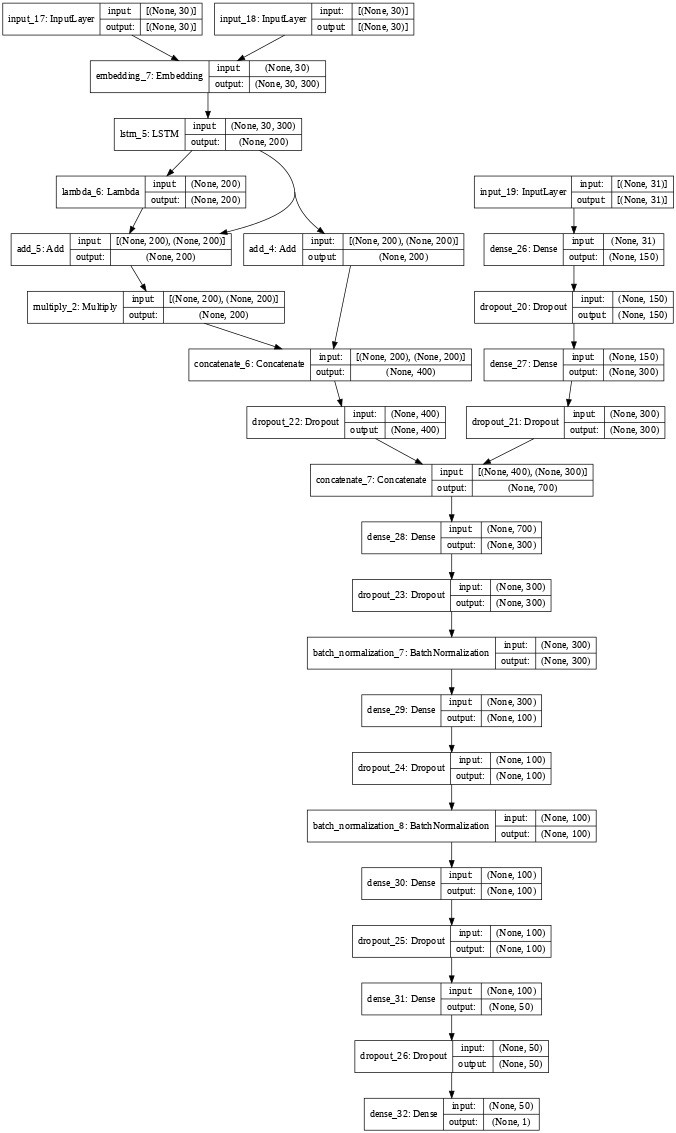

In [39]:
tf.keras.utils.plot_model(lstm, to_file="lstm.png", show_shapes=True,dpi=50)